# Extract time series parameters from flow and use to predict extreme snowmelt

In [51]:
import pandas as pd
import numpy as np
from collections import Counter

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold, cross_validate
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import make_scorer, precision_recall_curve, auc, classification_report, explained_variance_score, mean_squared_error, r2_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from matplotlib import pyplot as plt

In [30]:
from tsfresh import extract_features, extract_relevant_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction.settings import MinimalFCParameters
from tsfresh.utilities.dataframe_functions import roll_time_series


In [2]:
# setup for search grid
from scipy.stats import loguniform


class loguniform_int:
    """Integer valued version of the log-uniform distribution"""

    def __init__(self, a, b):
        self._distribution = loguniform(a, b)

    def rvs(self, *args, **kwargs):
        """Random variable sample"""
        return self._distribution.rvs(*args, **kwargs).astype(int)


In [2]:
# build scorer function
def auc_pr_score(y_true, y_pred):
	precision, recall, _ = precision_recall_curve(y_true, y_pred)
	return auc(recall, precision)


auc_pr = make_scorer(auc_pr_score, greater_is_better=True)


## Create rolled dataframe 

In [2]:
all_data_clean = pd.read_csv('../all_data_clean.csv')

all_data_clean.head()


,Unnamed: 0,date,snow_depth,depth_diff,binary,flow_site_id,snow_site_id,distance,flow,year,month,flow_prev_month,flow_prev_month_max,site_id
0,0,1945-05-23,0.0,0.0,0,51.0,157010.0,35296.19718,182.0,1945,5,413.3518,1746.0,51.0 157010.0
1,1,1945-05-24,0.0,0.0,0,51.0,157010.0,35296.19718,176.0,1945,5,413.3518,1746.0,51.0 157010.0
2,2,1945-05-25,0.0,0.0,0,51.0,157010.0,35296.19718,164.0,1945,5,413.3518,1746.0,51.0 157010.0
3,3,1945-05-26,0.0,0.0,0,51.0,157010.0,35296.19718,152.0,1945,5,413.3518,1746.0,51.0 157010.0
4,4,1945-05-27,0.0,0.0,0,51.0,157010.0,35296.19718,143.0,1945,5,413.3518,1746.0,51.0 157010.0


In [11]:

df_rolled = roll_time_series(
    all_data_clean[['date', 'site_id', 'flow', 'binary']], column_id="site_id", column_sort="date", max_timeshift=30, min_timeshift=29, n_jobs=20)


Rolling: 100%|██████████| 100/100 [20:02<00:00, 12.02s/it] 


In [12]:
df_rolled

,date,site_id,flow,binary,id
12202251,1945-01-23,100.0 122510.0,97.0,0,"(100.0 122510.0, 1945-02-21)"
12202252,1945-01-24,100.0 122510.0,97.0,0,"(100.0 122510.0, 1945-02-21)"
12202253,1945-01-25,100.0 122510.0,95.0,0,"(100.0 122510.0, 1945-02-21)"
12202254,1945-01-26,100.0 122510.0,95.0,0,"(100.0 122510.0, 1945-02-21)"
12202255,1945-01-27,100.0 122510.0,94.0,1,"(100.0 122510.0, 1945-02-21)"
...,...,...,...,...,...
15189511,1959-10-24,937.0 104720.0,2.7,0,"(937.0 104720.0, 1959-10-31)"
15189512,1959-10-28,937.0 104720.0,3.3,0,"(937.0 104720.0, 1959-10-31)"
15189513,1959-10-29,937.0 104720.0,3.5,0,"(937.0 104720.0, 1959-10-31)"
15189514,1959-10-30,937.0 104720.0,2.8,0,"(937.0 104720.0, 1959-10-31)"


In [13]:
df_rolled.to_csv('../df_rolled.csv', index=False)

## Extract minimal timeseries features

In [21]:
df_rolled = pd.read_csv('../df_rolled.csv')


In [27]:
df_rolled

,date,site_id,flow,binary,id
0,1945-01-23,100.0 122510.0,97.0,0,"('100.0 122510.0', '1945-02-21')"
1,1945-01-24,100.0 122510.0,97.0,0,"('100.0 122510.0', '1945-02-21')"
2,1945-01-25,100.0 122510.0,95.0,0,"('100.0 122510.0', '1945-02-21')"
3,1945-01-26,100.0 122510.0,95.0,0,"('100.0 122510.0', '1945-02-21')"
4,1945-01-27,100.0 122510.0,94.0,1,"('100.0 122510.0', '1945-02-21')"
...,...,...,...,...,...
46453011,1959-10-24,937.0 104720.0,2.7,0,"('937.0 104720.0', '1959-10-31')"
46453012,1959-10-28,937.0 104720.0,3.3,0,"('937.0 104720.0', '1959-10-31')"
46453013,1959-10-29,937.0 104720.0,3.5,0,"('937.0 104720.0', '1959-10-31')"
46453014,1959-10-30,937.0 104720.0,2.8,0,"('937.0 104720.0', '1959-10-31')"


In [4]:
# extract timeseries features

X_features_all = extract_features(
	df_rolled.drop(["binary"], axis=1), column_id='id', column_sort='date', column_value="flow", 
	n_jobs=20, disable_progressbar=False, default_fc_parameters=MinimalFCParameters())


X_features_all.head()


Feature Extraction:   0%|          | 0/100 [00:00<?, ?it/s]

In [8]:
X_features_all.to_csv('../df_extracted_min.csv')

## Undersample minimal timeseries feature dataset and run Random Forest model

In [3]:
X_features_all = pd.read_csv('../df_extracted_min.csv')


In [4]:
import ast

X_features_all['unique_id'] = X_features_all['Unnamed: 0'].apply(ast.literal_eval)
X_features_all = X_features_all.drop('Unnamed: 0', axis=1)


In [5]:
X_features_all.head()


,flow__sum_values,flow__median,flow__mean,flow__length,flow__standard_deviation,flow__variance,flow__root_mean_square,flow__maximum,flow__minimum,unique_id
0,2873.0,95.0,95.766667,30.0,1.891795,3.578889,95.785350,100.0,92.0,"(100.0 122510.0, 1945-02-21)"
1,2968.0,95.0,95.741935,31.0,1.865955,3.481790,95.760117,100.0,92.0,"(100.0 122510.0, 1945-02-22)"
2,2964.0,95.0,95.612903,31.0,1.912226,3.656608,95.632023,100.0,92.0,"(100.0 122510.0, 1945-02-23)"
3,2958.0,95.0,95.419355,31.0,2.059975,4.243496,95.441588,100.0,91.0,"(100.0 122510.0, 1945-02-24)"
4,2955.0,95.0,95.322581,31.0,2.146071,4.605619,95.346736,100.0,91.0,"(100.0 122510.0, 1945-02-25)"


In [6]:
all_data_clean = pd.read_csv('../all_data_clean.csv')

all_data_clean['unique_id'] = list(zip(all_data_clean.site_id, all_data_clean.date))


In [7]:
X_features_all = pd.merge(X_features_all, all_data_clean[['binary', 'unique_id']], how='left', on='unique_id')

In [8]:
X_features_all.head()


,flow__sum_values,flow__median,flow__mean,flow__length,flow__standard_deviation,flow__variance,flow__root_mean_square,flow__maximum,flow__minimum,unique_id,binary
0,2873.0,95.0,95.766667,30.0,1.891795,3.578889,95.785350,100.0,92.0,"(100.0 122510.0, 1945-02-21)",0
1,2968.0,95.0,95.741935,31.0,1.865955,3.481790,95.760117,100.0,92.0,"(100.0 122510.0, 1945-02-22)",0
2,2964.0,95.0,95.612903,31.0,1.912226,3.656608,95.632023,100.0,92.0,"(100.0 122510.0, 1945-02-23)",0
3,2958.0,95.0,95.419355,31.0,2.059975,4.243496,95.441588,100.0,91.0,"(100.0 122510.0, 1945-02-24)",0
4,2955.0,95.0,95.322581,31.0,2.146071,4.605619,95.346736,100.0,91.0,"(100.0 122510.0, 1945-02-25)",0


In [9]:
X_features_all = X_features_all.set_index(X_features_all['unique_id'], drop=True)


In [10]:
y1 = X_features_all['binary']

In [11]:
Counter(y1)

Counter({0: 1413465, 1: 85028})

In [12]:
X_features_all.head()


,flow__sum_values,flow__median,flow__mean,flow__length,flow__standard_deviation,flow__variance,flow__root_mean_square,flow__maximum,flow__minimum,unique_id,binary
unique_id,,,,,,,,,,,
"(100.0 122510.0, 1945-02-21)",2873.0,95.0,95.766667,30.0,1.891795,3.578889,95.785350,100.0,92.0,"(100.0 122510.0, 1945-02-21)",0
"(100.0 122510.0, 1945-02-22)",2968.0,95.0,95.741935,31.0,1.865955,3.481790,95.760117,100.0,92.0,"(100.0 122510.0, 1945-02-22)",0
"(100.0 122510.0, 1945-02-23)",2964.0,95.0,95.612903,31.0,1.912226,3.656608,95.632023,100.0,92.0,"(100.0 122510.0, 1945-02-23)",0
"(100.0 122510.0, 1945-02-24)",2958.0,95.0,95.419355,31.0,2.059975,4.243496,95.441588,100.0,91.0,"(100.0 122510.0, 1945-02-24)",0
"(100.0 122510.0, 1945-02-25)",2955.0,95.0,95.322581,31.0,2.146071,4.605619,95.346736,100.0,91.0,"(100.0 122510.0, 1945-02-25)",0


In [14]:
# undersample to balance classes
from imblearn.under_sampling import RandomUnderSampler, NearMiss, OneSidedSelection

# undersample = RandomUnderSampler(sampling_strategy='majority')
# undersample = RandomUnderSampler(sampling_strategy=0.5)
undersample = NearMiss(version=3, n_neighbors=3)
# undersample = OneSidedSelection(n_jobs=20)
X_under, y_under = undersample.fit_resample(
    X_features_all.drop(columns=['binary', 'unique_id']), y1)


In [15]:
X_under.index = X_features_all.index[undersample.sample_indices_]


In [16]:
Counter(y_under)

Counter({0: 1395580, 1: 85028})

In [17]:
# split into train and test sets
X_filtered_train, X_filtered_test, y_train, y_test = train_test_split(
    X_under, y_under, test_size=.4)

classifier_filtered = RandomForestClassifier()
classifier_filtered.fit(X_filtered_train, y_train)
print(classification_report(y_test, classifier_filtered.predict(X_filtered_test)))


              precision    recall  f1-score   support

           0       0.95      0.99      0.97    558162
           1       0.45      0.16      0.24     34082

    accuracy                           0.94    592244
   macro avg       0.70      0.57      0.60    592244
weighted avg       0.92      0.94      0.93    592244



In [20]:
auc_pr_score(y_test, classifier_filtered.predict(X_filtered_test))


0.3300969426807061

In [ ]:
df_rolled['unique_id'] = df_rolled['id'].apply(ast.literal_eval)
df_rolled.unique_id

0           (100.0 122510.0, 1945-02-21)
1           (100.0 122510.0, 1945-02-21)
2           (100.0 122510.0, 1945-02-21)
3           (100.0 122510.0, 1945-02-21)
4           (100.0 122510.0, 1945-02-21)
                        ...             
46453011    (937.0 104720.0, 1959-10-31)
46453012    (937.0 104720.0, 1959-10-31)
46453013    (937.0 104720.0, 1959-10-31)
46453014    (937.0 104720.0, 1959-10-31)
46453015    (937.0 104720.0, 1959-10-31)
Name: unique_id, Length: 46453016, dtype: object

In [ ]:
X_under.head()

,flow__sum_values,flow__median,flow__mean,flow__length,flow__standard_deviation,flow__variance,flow__root_mean_square,flow__maximum,flow__minimum
unique_id,,,,,,,,,
"(18.0 180760.0, 1936-11-08)",20169.6722,123.0102,650.634587,31.0,831.123058,690765.537975,1055.505047,2103.1576,93.9771
"(18.0 180760.0, 1936-11-10)",20169.8528,120.8060,650.640413,31.0,831.121073,690762.237510,1055.507075,2103.1576,93.9771
"(18.0 180760.0, 1936-11-07)",20188.9679,123.0102,651.257029,31.0,830.722022,690099.077869,1055.573207,2103.1576,93.9771
"(16722.0 163950.0, 1997-06-25)",48450.0000,1570.0000,1562.903226,31.0,284.697843,81052.861602,1588.621841,2000.0000,1000.0000
"(16722.0 163950.0, 1952-07-08)",48055.0000,1621.0000,1550.161290,31.0,281.568315,79280.715921,1575.525545,2027.0000,911.0000


In [ ]:
X_under_all = df_rolled[df_rolled.unique_id.isin(X_under.index)]
X_under_all


,date,site_id,flow,binary,id,unique_id
433,1945-02-05,100.0 122510.0,98.0,0,"('100.0 122510.0', '1945-03-07')","(100.0 122510.0, 1945-03-07)"
434,1945-02-06,100.0 122510.0,97.0,0,"('100.0 122510.0', '1945-03-07')","(100.0 122510.0, 1945-03-07)"
435,1945-02-07,100.0 122510.0,100.0,0,"('100.0 122510.0', '1945-03-07')","(100.0 122510.0, 1945-03-07)"
436,1945-02-08,100.0 122510.0,98.0,0,"('100.0 122510.0', '1945-03-07')","(100.0 122510.0, 1945-03-07)"
437,1945-02-09,100.0 122510.0,98.0,0,"('100.0 122510.0', '1945-03-07')","(100.0 122510.0, 1945-03-07)"
...,...,...,...,...,...,...
46452763,1959-10-16,937.0 104720.0,5.6,0,"('937.0 104720.0', '1959-10-20')","(937.0 104720.0, 1959-10-20)"
46452764,1959-10-17,937.0 104720.0,3.1,0,"('937.0 104720.0', '1959-10-20')","(937.0 104720.0, 1959-10-20)"
46452765,1959-10-18,937.0 104720.0,3.8,0,"('937.0 104720.0', '1959-10-20')","(937.0 104720.0, 1959-10-20)"
46452766,1959-10-19,937.0 104720.0,4.7,0,"('937.0 104720.0', '1959-10-20')","(937.0 104720.0, 1959-10-20)"


In [ ]:
X_under_all.to_csv('../df_undersampled_nearmiss.csv', index=False)


## Extract complete set of timeseries features on undersampled dataframe

In [3]:
X_under_all = pd.read_csv('../df_undersampled_nearmiss.csv')


In [4]:
# Split dataframe in two to avoid problems with memory

X_under_all.sort_values(by=['unique_id'])

X_under_1 = X_under_all[:len(X_under_all)//2]
X_under_2 = X_under_all[len(X_under_all)//2:]


In [5]:
X_features_under_1 = extract_features(
	X_under_1.drop(["binary", "id"], axis=1), column_id='unique_id', column_sort='date', column_value="flow",
	n_jobs=10, disable_progressbar=False)


Feature Extraction: 100%|██████████| 50/50 [09:38<00:00, 11.58s/it]  


In [6]:
X_features_under_1.to_csv('../df_extracted_1_nearmiss.csv')


In [5]:
X_features_under_2 = extract_features(
	X_under_2.drop(["binary", "id"], axis=1), column_id='unique_id', column_sort='date', column_value="flow",
	n_jobs=10, disable_progressbar=False)


Feature Extraction: 100%|██████████| 50/50 [09:48<00:00, 11.78s/it]  


In [6]:
X_features_under_2.to_csv('../df_extracted_2_nearmiss.csv')


In [2]:
X_features_under_1 = pd.read_csv('../df_extracted_1_nearmiss.csv')
X_features_under_2 = pd.read_csv('../df_extracted_2_nearmiss.csv')

X_features_under_all = pd.concat([X_features_under_1, X_features_under_2])
X_features_under_all.shape

(170057, 788)

In [3]:
X_features_under_all.to_csv('../df_extracted_all_nearmiss.csv', index=False)

## Build Random Forest model with complete set of extracted timeseries parameters

In [18]:
import ast

X_features_under_all = pd.read_csv('../df_extracted_all_nearmiss.csv')

all_data_clean = pd.read_csv('../all_data_clean.csv')

all_data_clean['unique_id'] = list(
    zip(all_data_clean.site_id, all_data_clean.date))

X_features_under_all['unique_id'] = X_features_under_all['Unnamed: 0'].apply(
    ast.literal_eval)
X_features_under_all = pd.merge(X_features_under_all, all_data_clean[[
    'binary', 'unique_id']], how='left', on='unique_id')
X_features_under_all = X_features_under_all.set_index(
    X_features_under_all['unique_id'], drop=True)
y_under = X_features_under_all['binary']
X_features_under_filtered = X_features_under_all.dropna(axis=1)
X_features_under_filtered = X_features_under_filtered.drop(
    columns=['unique_id', 'Unnamed: 0', 'binary'])
X_features_under_filtered.head()


,flow__variance_larger_than_standard_deviation,flow__has_duplicate_max,flow__has_duplicate_min,flow__has_duplicate,flow__sum_values,flow__abs_energy,flow__mean_abs_change,flow__mean_change,flow__mean_second_derivative_central,flow__median,...,flow__ratio_beyond_r_sigma__r_10,flow__count_above__t_0,flow__count_below__t_0,flow__lempel_ziv_complexity__bins_2,flow__lempel_ziv_complexity__bins_3,flow__lempel_ziv_complexity__bins_5,flow__lempel_ziv_complexity__bins_10,flow__lempel_ziv_complexity__bins_100,flow__permutation_entropy__dimension_3__tau_1,flow__permutation_entropy__dimension_4__tau_1
unique_id,,,,,,,,,,,,,,,,,,,,,
"(100.0 122510.0, 1945-03-07)",1.0,0.0,1.0,1.0,2965.0,283843.0,1.466667,0.066667,0.000000,95.0,...,0.0,1.0,0.0,0.258065,0.354839,0.516129,0.612903,0.612903,1.711908,2.679544
"(100.0 122510.0, 1945-03-12)",1.0,0.0,1.0,1.0,2951.0,281161.0,1.433333,-0.033333,-0.051724,95.0,...,0.0,1.0,0.0,0.258065,0.387097,0.483871,0.645161,0.612903,1.637283,2.493637
"(100.0 122510.0, 1945-03-13)",1.0,0.0,1.0,1.0,2953.0,281545.0,1.400000,-0.066667,0.086207,95.0,...,0.0,1.0,0.0,0.258065,0.419355,0.516129,0.612903,0.645161,1.599295,2.446599
"(100.0 122510.0, 1945-03-18)",1.0,0.0,1.0,1.0,2950.0,280964.0,1.533333,0.000000,0.034483,94.0,...,0.0,1.0,0.0,0.258065,0.419355,0.483871,0.612903,0.612903,1.636381,2.483974
"(100.0 122510.0, 1945-03-24)",1.0,0.0,0.0,1.0,2931.0,277465.0,1.733333,-0.200000,0.051724,94.0,...,0.0,1.0,0.0,0.258065,0.387097,0.483871,0.580645,0.677419,1.720172,2.712839


In [21]:
# split into train and test sets
X_filtered_train, X_filtered_test, y_train, y_test = train_test_split(
    X_features_under_filtered, y_under, test_size=.4)

classifier_filtered = RandomForestClassifier(n_jobs=-1, random_state=42)
classifier_filtered.fit(X_filtered_train, y_train)
print(classification_report(y_test, classifier_filtered.predict(X_filtered_test)))


              precision    recall  f1-score   support

           0       0.76      0.84      0.80     33869
           1       0.83      0.74      0.78     34154

    accuracy                           0.79     68023
   macro avg       0.79      0.79      0.79     68023
weighted avg       0.79      0.79      0.79     68023



In [22]:
auc_pr_score(y_test, classifier_filtered.predict(X_filtered_test))

0.8481688207836791

In [55]:
# try automatic feature selection

sel = SelectFromModel(RandomForestClassifier(n_jobs=-1, random_state=42))
sel.fit(X_filtered_train, y_train)
selected_feat = X_filtered_train.columns[(sel.get_support())]

In [56]:
X_selected = X_features_under_filtered[selected_feat]
X_filtered_train, X_filtered_test, y_train, y_test = train_test_split(
    X_selected, y_under, test_size=.4)

classifier_filtered = RandomForestClassifier(n_jobs=-1, random_state=42)
classifier_filtered.fit(X_filtered_train, y_train)
print(classification_report(y_test, classifier_filtered.predict(X_filtered_test)))
auc_pr_score(y_test, classifier_filtered.predict(X_filtered_test))


              precision    recall  f1-score   support

           0       0.76      0.84      0.80     34131
           1       0.82      0.74      0.78     33892

    accuracy                           0.79     68023
   macro avg       0.79      0.79      0.79     68023
weighted avg       0.79      0.79      0.79     68023



0.8443108218508102

<ipython-input-58-ac29b18840f8>:15: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


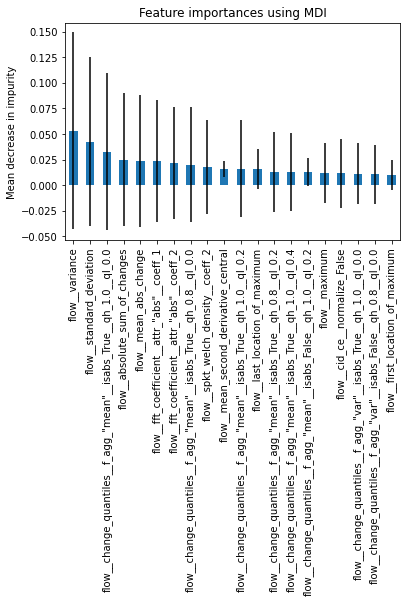

In [58]:
importances = classifier_filtered.feature_importances_
forest_importances = pd.Series(importances, index=X_selected.columns)

main_features = forest_importances.nlargest(20)
main_features_indices = pd.Series(importances).nlargest(20).index

std = np.std(
    [tree.feature_importances_ for tree in classifier_filtered.estimators_], axis=0)
main_std = std[main_features_indices]

fig, ax = plt.subplots()
main_features.plot.bar(yerr=main_std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()


## Select relevant features and run model only on those

In [29]:
# select relevant features
X_filtered = select_features(X_features_under_filtered, y_under, n_jobs=20)

X_filtered.head()


,flow__sum_values,"flow__change_quantiles__f_agg_""var""__isabs_False__qh_0.6__ql_0.2","flow__change_quantiles__f_agg_""mean""__isabs_True__qh_0.6__ql_0.2","flow__change_quantiles__f_agg_""var""__isabs_True__qh_0.6__ql_0.2","flow__change_quantiles__f_agg_""mean""__isabs_False__qh_0.8__ql_0.2","flow__change_quantiles__f_agg_""var""__isabs_False__qh_0.8__ql_0.2","flow__change_quantiles__f_agg_""mean""__isabs_True__qh_0.8__ql_0.2","flow__change_quantiles__f_agg_""var""__isabs_True__qh_0.8__ql_0.2","flow__change_quantiles__f_agg_""mean""__isabs_False__qh_1.0__ql_0.2","flow__change_quantiles__f_agg_""var""__isabs_False__qh_1.0__ql_0.2",...,flow__number_crossing_m__m_0,flow__ratio_beyond_r_sigma__r_5,flow__symmetry_looking__r_0.15000000000000002,flow__skewness,flow__ratio_beyond_r_sigma__r_2.5,flow__last_location_of_minimum,"flow__fft_coefficient__attr_""angle""__coeff_1",flow__ar_coefficient__coeff_10__k_10,"flow__fft_coefficient__attr_""angle""__coeff_0",flow__symmetry_looking__r_0.2
unique_id,,,,,,,,,,,,,,,,,,,,,
"(100.0 122510.0, 1945-03-07)",2965.0,0.913580,0.666667,0.666667,-0.692308,1.136095,0.846154,0.899408,0.000000,3.727273,...,0.0,0.0,1.0,0.143617,0.0,0.709677,-9.277619,-0.665564,0.0,1.0
"(100.0 122510.0, 1945-03-12)",2951.0,0.690000,0.500000,0.450000,-0.692308,2.366864,1.000000,1.846154,-0.136364,3.935950,...,0.0,0.0,1.0,0.488456,0.0,0.548387,58.448917,-0.372727,0.0,1.0
"(100.0 122510.0, 1945-03-13)",2953.0,0.690000,0.500000,0.450000,-0.428571,3.102041,1.142857,1.979592,-0.181818,3.603306,...,0.0,0.0,1.0,0.416204,0.0,0.516129,67.564143,0.017550,0.0,1.0
"(100.0 122510.0, 1945-03-18)",2950.0,0.750000,0.500000,0.500000,-0.400000,4.373333,1.466667,2.382222,-0.090909,4.446281,...,0.0,0.0,1.0,0.474006,0.0,0.354839,129.662848,0.111848,0.0,1.0
"(100.0 122510.0, 1945-03-24)",2931.0,2.359375,1.125000,1.109375,-0.466667,5.182222,1.800000,2.160000,-0.136364,5.026860,...,0.0,0.0,1.0,0.208129,0.0,0.967742,-157.725248,-0.019770,0.0,1.0


In [15]:
# split into train and test sets
X_filtered_train, X_filtered_test, y_train, y_test = train_test_split(
    X_filtered, y_under, test_size=.4)

classifier_filtered = RandomForestClassifier(n_jobs=-1, random_state=42)
classifier_filtered.fit(X_filtered_train, y_train)
print(classification_report(y_test, classifier_filtered.predict(X_filtered_test)))


              precision    recall  f1-score   support

           0       0.76      0.84      0.80     34012
           1       0.82      0.74      0.78     34011

    accuracy                           0.79     68023
   macro avg       0.79      0.79      0.79     68023
weighted avg       0.79      0.79      0.79     68023



In [ ]:
auc_pr_score(y_test, classifier_filtered.predict(X_filtered_test))


In [33]:
# try with grid search


kf = KFold()
index_output = kf.split(X_filtered)

clf = RandomForestClassifier(random_state=42, verbose=0, n_jobs=-1)

param_distributions = {
	'n_estimators': loguniform_int(2, 256),
	'criterion': ['gini', 'entropy'],
	'min_samples_split': loguniform_int(2, 256),
	'min_samples_leaf': loguniform_int(1, 100),
	'class_weight': [{0: 1, 1: 10}, {0: 1, 1: 5}, {0: 1, 1: 2}, {0: 1, 1: 1}],
}

model_random_search = RandomizedSearchCV(
    clf, param_distributions=param_distributions, n_iter=200, n_jobs=-1, scoring=auc_pr,
    cv=index_output, verbose=1,
)
model_random_search.fit(X_filtered, y_under)
n_estimators = model_random_search.best_params_['n_estimators']
criterion = model_random_search.best_params_['criterion']
min_samples_split = model_random_search.best_params_['min_samples_split']
min_samples_leaf = model_random_search.best_params_['min_samples_leaf']
class_weight = model_random_search.best_params_['class_weight']
model_random_search.best_params_


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


/home/cecilia/.local/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


{'class_weight': {0: 1, 1: 1},
 'criterion': 'entropy',
 'min_samples_leaf': 4,
 'min_samples_split': 67,
 'n_estimators': 117}

In [34]:
# random forest - cross validation with new parameters

new_regressor = RandomForestClassifier(
    random_state=42,
   	n_jobs=-1, verbose=0,
   	criterion=criterion,
   	min_samples_leaf=min_samples_leaf,
   	min_samples_split=min_samples_split,
   	n_estimators=n_estimators
)
index_output = kf.split(X_filtered)

cv_results = cross_validate(
    new_regressor,
    X_filtered,
    y_under,
    cv=index_output,
    scoring=auc_pr,
)

print(np.mean(cv_results['test_score']))


0.8310080015596524


## Predict snow diff using complete timeseries parameters

In [3]:
import ast
X_features_under_all = pd.read_csv('../df_extracted_all_nearmiss.csv')
all_data_clean = pd.read_csv('../all_data_clean.csv')

all_data_clean['unique_id'] = list(
    zip(all_data_clean.site_id, all_data_clean.date))

X_features_under_all['unique_id'] = X_features_under_all['Unnamed: 0'].apply(
    ast.literal_eval)
X_features_under_all = pd.merge(X_features_under_all, all_data_clean[[
    'depth_diff', 'unique_id']], how='left', on='unique_id')
X_features_under_all = X_features_under_all.set_index(
    X_features_under_all['unique_id'], drop=True)

y_under = X_features_under_all['depth_diff']
X_features_under_filtered = X_features_under_all.dropna(axis=1)
X_features_under_filtered = X_features_under_filtered.drop(
    columns=['unique_id', 'Unnamed: 0', 'depth_diff'])
X_features_under_filtered.head()




,flow__variance_larger_than_standard_deviation,flow__has_duplicate_max,flow__has_duplicate_min,flow__has_duplicate,flow__sum_values,flow__abs_energy,flow__mean_abs_change,flow__mean_change,flow__mean_second_derivative_central,flow__median,...,flow__ratio_beyond_r_sigma__r_10,flow__count_above__t_0,flow__count_below__t_0,flow__lempel_ziv_complexity__bins_2,flow__lempel_ziv_complexity__bins_3,flow__lempel_ziv_complexity__bins_5,flow__lempel_ziv_complexity__bins_10,flow__lempel_ziv_complexity__bins_100,flow__permutation_entropy__dimension_3__tau_1,flow__permutation_entropy__dimension_4__tau_1
unique_id,,,,,,,,,,,,,,,,,,,,,
"(100.0 122510.0, 1945-03-07)",1.0,0.0,1.0,1.0,2965.0,283843.0,1.466667,0.066667,0.000000,95.0,...,0.0,1.0,0.0,0.258065,0.354839,0.516129,0.612903,0.612903,1.711908,2.679544
"(100.0 122510.0, 1945-03-12)",1.0,0.0,1.0,1.0,2951.0,281161.0,1.433333,-0.033333,-0.051724,95.0,...,0.0,1.0,0.0,0.258065,0.387097,0.483871,0.645161,0.612903,1.637283,2.493637
"(100.0 122510.0, 1945-03-13)",1.0,0.0,1.0,1.0,2953.0,281545.0,1.400000,-0.066667,0.086207,95.0,...,0.0,1.0,0.0,0.258065,0.419355,0.516129,0.612903,0.645161,1.599295,2.446599
"(100.0 122510.0, 1945-03-18)",1.0,0.0,1.0,1.0,2950.0,280964.0,1.533333,0.000000,0.034483,94.0,...,0.0,1.0,0.0,0.258065,0.419355,0.483871,0.612903,0.612903,1.636381,2.483974
"(100.0 122510.0, 1945-03-24)",1.0,0.0,0.0,1.0,2931.0,277465.0,1.733333,-0.200000,0.051724,94.0,...,0.0,1.0,0.0,0.258065,0.387097,0.483871,0.580645,0.677419,1.720172,2.712839


In [9]:
# split into train and test sets
X_filtered_train, X_filtered_test, y_train, y_test = train_test_split(
    X_features_under_filtered, y_under, test_size=.4)

classifier_filtered = RandomForestRegressor(verbose=1, n_jobs=-1, random_state=42)
classifier_filtered.fit(X_filtered_train, y_train)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   43.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.5min finished


RandomForestRegressor(n_jobs=-1, random_state=42, verbose=1)

In [12]:
y_pred = classifier_filtered.predict(X_filtered_test)
print('Explained variance score: {0}, MSE: {1}, R2: {2}'.format(explained_variance_score(y_test, y_pred),
                                                                mean_squared_error(y_test, y_pred), r2_score(y_test, y_pred)))


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s


Explained variance score: 0.2776116941364054, MSE: 0.002773097761625455, R2: 0.2769179674691532


[Parallel(n_jobs=20)]: Done 100 out of 100 | elapsed:    0.5s finished


## Exploration of most meaningful parameters

In [23]:

scaler = StandardScaler().fit_transform(X_features_under_filtered)
data_standardized = pd.DataFrame(
    scaler, columns=X_features_under_filtered.columns)
pca = PCA(random_state=42, n_components=5)
pca.fit(data_standardized)
print(pca.explained_variance_ratio_)


[0.20843906 0.09769814 0.08983928 0.06093327 0.04412506]


Text(0, 0.5, '2nd PC')

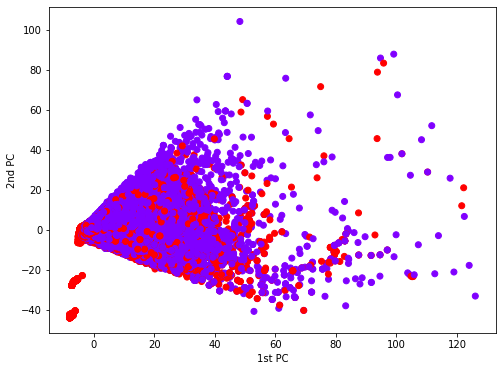

In [29]:
x_pca = pca.transform(data_standardized)

plt.figure(figsize=(8, 6))
plt.scatter(x=x_pca[:, 0], y=x_pca[:, 1],
            c=y_under, cmap='rainbow')
plt.xlabel('1st PC')
plt.ylabel('2nd PC')
